### Homework 4: Deep Learning
#### Zachary Karas
#### z.karas@vanderbilt.edu
#### karasze

In [362]:
import torch
import random
import sklearn
import torchvision
import numpy as np
import pandas as pd
import seaborn as sn
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.distributions as dist
import torchvision.datasets as datasets
import torchvision.transforms as transform
from scipy.stats import multivariate_normal
from sklearn.datasets import make_swiss_roll
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

#### Question 1: Auto-Encoding

In [146]:
# Making the dataset
n = 2500
x, color = make_swiss_roll(2500)
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [147]:
print(x.shape)

(2500, 3)


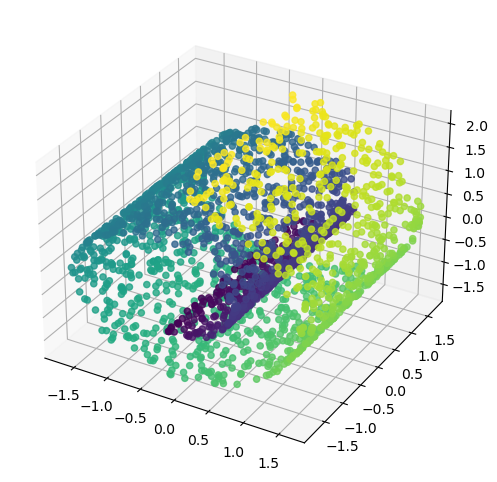

In [148]:
# Plotting it out
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c = color, alpha=0.8)

##### 1.1 Sliced-Wasserstein Auto-encoder
###### 1.1.1 Designing the SWAE

torch.Size([2500, 2])


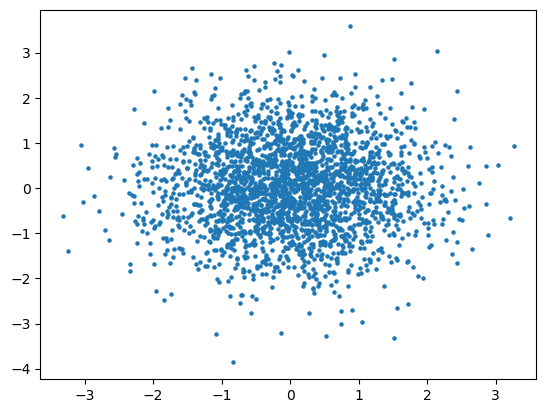

In [150]:
# # Created prior distribution
prior = dist.MultivariateNormal(torch.zeros(2), torch.eye(2)).sample((2500,))

print(prior.shape)
plt.scatter(prior[:,0], prior[:,1], s=5)
plt.show()

In [151]:
# function for creating L slices/lines at random angles 
def vectors(L):
    angles = [w/np.sqrt((w**2).sum()) for w in np.random.normal(size=(L, endim))]
    return angles # unit_vectors


In [152]:
# Sliced Wasserstein
# q is prior distribution
# p is latent distribution
def sliced_wass(p, q, L):
    assert len(p) == len(q) 
    
    d = p.shape[1]# making sure length of latent 
                            # and prior distribution are equal
    thetas = torch.randn((L,d)).to(device)
    thetas /= torch.sqrt((thetas**2).sum(1)).unsqueeze(1)# angles
    projlat = torch.matmul(p, thetas.T)
    projpri = torch.matmul(q, thetas.T)
    
    # sorting the points to align the distributions
    projlat,_ = torch.sort(projlat, dim=1)
    projpri,_ = torch.sort(projpri, dim=1)
    
    # actual MSE loss calculation
    loss = (projlat.T - projpri.T)**2
    
    return torch.mean(loss)   

In [387]:
# slices L = 512
architecture = [3, 512, 512, 512,  2]
class SWAE(nn.Module):
    def __init__(self, architecture, encoding):
        super().__init__()
        self.activation = nn.ReLU()
        self.architecture = architecture
        
        # creating architecture for encoder
        encoder_arch = []
        for i in range(1, len(architecture)):
            encoder_arch.append(nn.Linear(architecture[i-1], architecture[i]))
            if i < len(architecture) - 1:
                encoder_arch.append(self.activation)
        
        self.encoder = nn.Sequential(*encoder_arch)   
        
        # architecture for linear layer
        self.latent = nn.Linear(architecture[-1], 2)
        
        # creating architecture for decoder
        #architecture.append(2) # appending 2 before reversing so dimensions agree with latent space
        architecture.reverse() # reversing architecture to use for decoder
        decoder_arch = []
        for i in range(1, len(architecture)):
            decoder_arch.append(nn.Linear(architecture[i-1], architecture[i]))
            if i < len(architecture) - 1:
                decoder_arch.append(self.activation)
                
        self.decoder = nn.Sequential(*decoder_arch)
        
    def forward(self, x, encoding):
        if encoding:
            x = self.encoder(x)   
        latent = self.latent(x)
        decoded = self.decoder(latent)
        return decoded, latent

swae = SWAE(architecture, encoding=True)
swae = swae.float()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(swae) # mirror arch for encoder/decoder


SWAE(
  (activation): ReLU()
  (encoder): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
  (latent): Linear(in_features=2, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)


In [388]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(swae.parameters(), lr=1e-3)

In [389]:
epochs = 20001
swlosses = []
rlosses = []

for e in range(epochs):
    optimizer.zero_grad()
    inputs = torch.from_numpy(x).float().to(device)
    outputs, latent = swae(inputs, encoding=True)
    
    wassloss = sliced_wass(latent, prior, 512)
    rloss = loss_fn(outputs, torch.from_numpy(x).float())
    swlosses.append(wassloss)
    rlosses.append(rloss)
    loss = 0.99*rloss + (0.01 * wassloss)
    loss.backward()
    optimizer.step()
    
    if e % 500 == 0:
        print(f"Epoch {e+1}/{epochs} | WassLoss: {wassloss:.4f} | RLoss: {rloss:.4f}")
    

Epoch 1/20001 | WassLoss: 0.6023 | RLoss: 1.0033
Epoch 501/20001 | WassLoss: 0.3471 | RLoss: 0.0327
Epoch 1001/20001 | WassLoss: 0.3140 | RLoss: 0.0048
Epoch 1501/20001 | WassLoss: 0.2928 | RLoss: 0.0030
Epoch 2001/20001 | WassLoss: 0.2856 | RLoss: 0.0021
Epoch 2501/20001 | WassLoss: 0.2817 | RLoss: 0.0016
Epoch 3001/20001 | WassLoss: 0.2765 | RLoss: 0.0030
Epoch 3501/20001 | WassLoss: 0.2763 | RLoss: 0.0023
Epoch 4001/20001 | WassLoss: 0.2715 | RLoss: 0.0006
Epoch 4501/20001 | WassLoss: 0.2744 | RLoss: 0.0004
Epoch 5001/20001 | WassLoss: 0.2676 | RLoss: 0.0003
Epoch 5501/20001 | WassLoss: 0.2669 | RLoss: 0.0003
Epoch 6001/20001 | WassLoss: 0.2604 | RLoss: 0.0003
Epoch 6501/20001 | WassLoss: 0.2599 | RLoss: 0.0003
Epoch 7001/20001 | WassLoss: 0.2606 | RLoss: 0.0005
Epoch 7501/20001 | WassLoss: 0.2582 | RLoss: 0.0019
Epoch 8001/20001 | WassLoss: 0.2671 | RLoss: 0.0012
Epoch 8501/20001 | WassLoss: 0.2707 | RLoss: 0.0004
Epoch 9001/20001 | WassLoss: 0.2590 | RLoss: 0.0012
Epoch 9501/20001

###### 1.1.2 Reconstruction loss and SW loss 

Text(0.5, 0, 'Epochs')

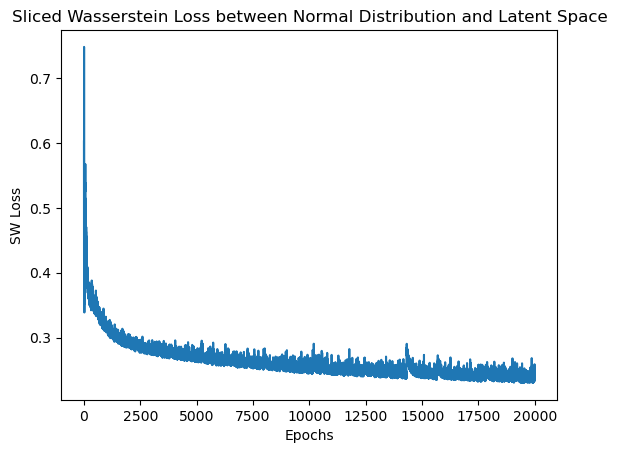

In [390]:
swloss_swae = [s.detach().numpy() for s in swlosses]
plt.plot(swloss_swae)
plt.title("Sliced Wasserstein Loss between Normal Distribution and Latent Space")
plt.ylabel("SW Loss")
plt.xlabel("Epochs")

Text(0, 0.5, 'Reconstruction Loss')

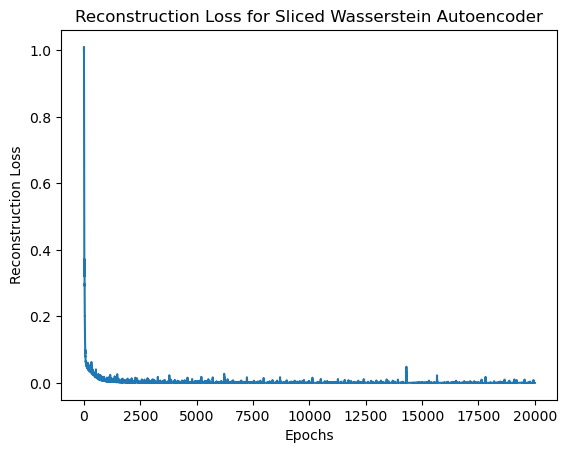

In [391]:
rloss = [r.item() for r in rlosses]
plt.plot(rloss)
plt.title("Reconstruction Loss for Sliced Wasserstein Autoencoder")
plt.xlabel("Epochs")
plt.ylabel("Reconstruction Loss")

###### 1.1.3 Encoded points

Text(0.5, 1.0, 'Encoded Points from SW Autoencoder')

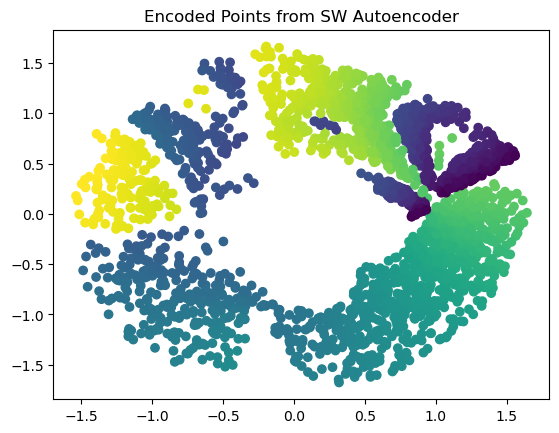

In [392]:
latent_np = latent.detach().numpy()
x_values = latent_np[:, 0]
y_values = latent_np[:, 1]

plt.scatter(x_values, y_values, c = color)
plt.title("Encoded Points from SW Autoencoder")

###### 1.1.4 Decoded points from prior distribution

Text(0.5, 0.98, 'Decoded points of Samples from SWAE Prior Distribution')

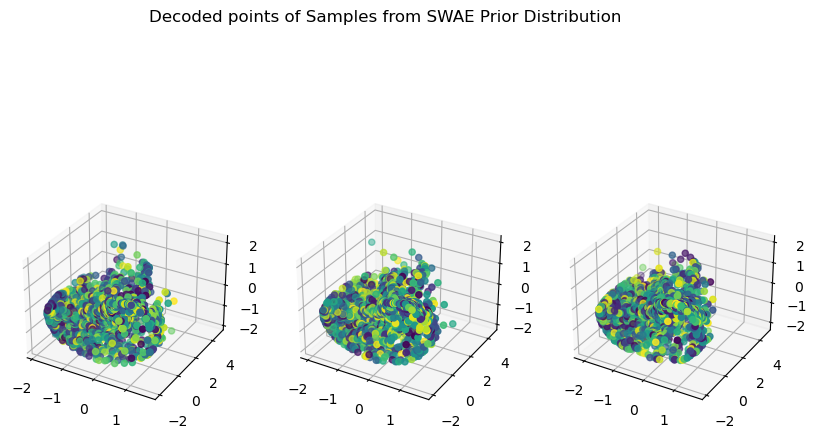

In [393]:
swae.eval()
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
plots = [ax1, ax2, ax3]
for i in range(3):
    sample = dist.MultivariateNormal(torch.zeros(2), torch.eye(2)).sample((2500,))
    output,latent = swae(sample, encoding=False)
    output = output.detach().numpy()
    plots[i].scatter(output[:, 0], output[:, 1], output[:, 2], c = color)

fig.suptitle("Decoded points of Samples from SWAE Prior Distribution")

Text(0.5, 0.92, 'Not Assigned, but SWAE reconstruction')

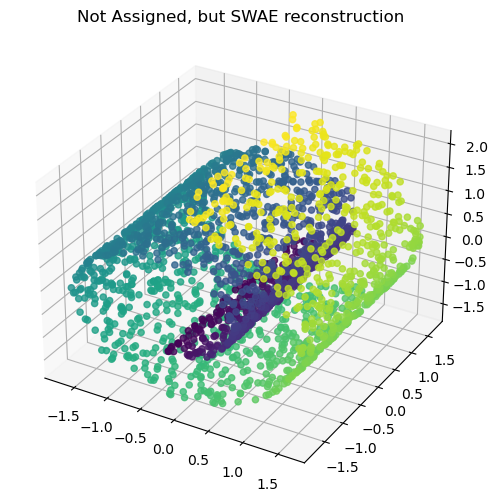

In [395]:
## Reconstruction
new = outputs.detach()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(new[:, 0], new[:, 1], new[:, 2], c = color, alpha=0.8)
plt.title("Not Assigned, but SWAE reconstruction")

##### 1.2 Variational Auto-Encoder
###### 1.2.1 Designing VAE with Normal prior distribution

In [241]:
class VAE(nn.Module):
    def __init__(self, encoding):
        super().__init__()
        
        self.activation = nn.LeakyReLU()
        self.en1 = nn.Linear(in_features=3, out_features=512)
        self.en2 = nn.Linear(in_features=512, out_features=512)
        self.en3 = nn.Linear(in_features=512, out_features=512)
        self.en4 = nn.Linear(in_features=512, out_features=512)
        
        self.musig = nn.Linear(in_features=512, out_features=3)
        
        self.de1 = nn.Linear(in_features=2, out_features=512)
        self.de2 = nn.Linear(in_features=512, out_features=512)
        self.de3 = nn.Linear(in_features=512, out_features=512)
        self.de4 = nn.Linear(in_features=512, out_features=3)
        
  
    def encoder(self, x):
        x = self.activation(self.en1(x))
        x = self.activation(self.en2(x))
        x = self.activation(self.en3(x))
        x = self.activation(self.en4(x))
        out = self.musig(x)
        mu,log_sigma=out[:,:2],out[:,-1]
        log_sigma=log_sigma.repeat(2,1).reshape(mu.shape[0],2)
        return mu, log_sigma
    
    def reparam(self, mu, sigma):
        std = torch.exp(0.5 * sigma)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def decoder(self, z):
        z = self.activation(self.de1(z))
        z = self.activation(self.de2(z))
        z = self.activation(self.de3(z))
        z = self.de4(z)
        return z
    
    def forward(self, x, encoding):
        if encoding:
            mu, sigma = self.encoder(x)
            x = self.reparam(mu, sigma)
            xhat = self.decoder(x)
            return xhat, mu, sigma
        else:
            xhat = self.decoder(x)
            return xhat

vae = VAE(encoding=True)
vae = vae.float()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)      

VAE(
  (activation): LeakyReLU(negative_slope=0.01)
  (en1): Linear(in_features=3, out_features=512, bias=True)
  (en2): Linear(in_features=512, out_features=512, bias=True)
  (en3): Linear(in_features=512, out_features=512, bias=True)
  (en4): Linear(in_features=512, out_features=512, bias=True)
  (musig): Linear(in_features=512, out_features=3, bias=True)
  (de1): Linear(in_features=2, out_features=512, bias=True)
  (de2): Linear(in_features=512, out_features=512, bias=True)
  (de3): Linear(in_features=512, out_features=512, bias=True)
  (de4): Linear(in_features=512, out_features=3, bias=True)
)

In [242]:
def KL_div(mu, sigma):
    return torch.mean(-0.5*torch.sum(1 + torch.log(sigma**2) - mu**2  - sigma**2,dim=1), dim=0)

In [243]:
loss_fn = nn.MSELoss()
optim_vae = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [244]:
epochs = 10001

kl_losses = []
rlosses_v = []
for e in range(epochs):
    optim_vae.zero_grad()
    inputs = torch.from_numpy(x).float().to(device)
    outputs, mu, sigma = vae(inputs, encoding=True)
    kl = 1e-2 * KL_div(mu, sigma)
    
    rl = loss_fn(outputs, inputs)
    loss = kl + rl
    loss.backward()
    optim_vae.step()
    kl_losses.append(kl)
    rlosses_v.append(rl)
    
    if e % 250 == 0:
        print(f'Epoch {e} | KL Loss {kl:.4f} | RLoss {rl:.4f} | Loss {loss:.4f}')

Epoch 0 | KL Loss 0.0739 | RLoss 1.0013 | Loss 1.0751
Epoch 250 | KL Loss 0.0695 | RLoss 0.0855 | Loss 0.1550
Epoch 500 | KL Loss 0.0736 | RLoss 0.0664 | Loss 0.1400
Epoch 750 | KL Loss 0.0801 | RLoss 0.0554 | Loss 0.1355
Epoch 1000 | KL Loss 0.0803 | RLoss 0.0523 | Loss 0.1326
Epoch 1250 | KL Loss 0.0793 | RLoss 0.0502 | Loss 0.1295
Epoch 1500 | KL Loss 0.0823 | RLoss 0.0487 | Loss 0.1310
Epoch 1750 | KL Loss 0.0828 | RLoss 0.0494 | Loss 0.1322
Epoch 2000 | KL Loss 0.0828 | RLoss 0.0485 | Loss 0.1313
Epoch 2250 | KL Loss 0.0804 | RLoss 0.0477 | Loss 0.1281
Epoch 2500 | KL Loss 0.0829 | RLoss 0.0487 | Loss 0.1316
Epoch 2750 | KL Loss 0.0800 | RLoss 0.0543 | Loss 0.1343
Epoch 3000 | KL Loss 0.0827 | RLoss 0.0485 | Loss 0.1312
Epoch 3250 | KL Loss 0.0769 | RLoss 0.0520 | Loss 0.1289
Epoch 3500 | KL Loss 0.0822 | RLoss 0.0453 | Loss 0.1276
Epoch 3750 | KL Loss 0.0812 | RLoss 0.0461 | Loss 0.1273
Epoch 4000 | KL Loss 0.0823 | RLoss 0.0498 | Loss 0.1320
Epoch 4250 | KL Loss 0.0806 | RLoss 0

Text(0.5, 0.92, 'Not assigned, but VAE Reconstruction')

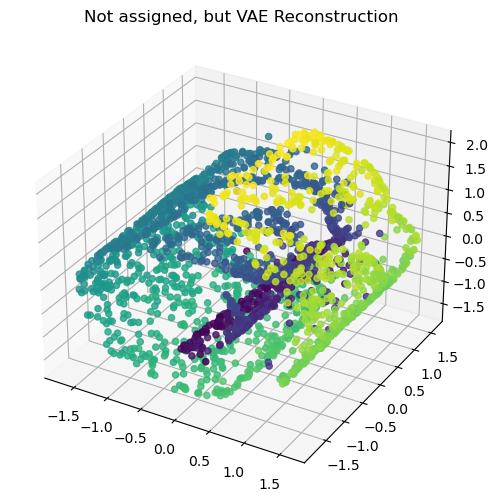

In [252]:
new = outputs.detach()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(new[:, 0], new[:, 1], new[:, 2], c = color, alpha=0.8)
plt.title("Not assigned, but VAE Reconstruction")

###### 1.2.2 Reconstruction loss

Text(0, 0.5, 'Reconstruction Loss')

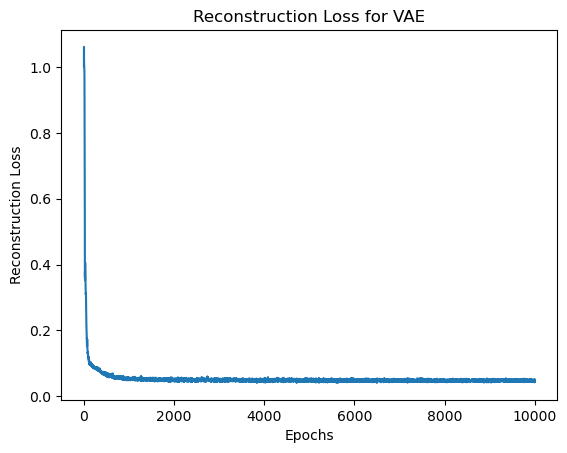

In [246]:
r_loss_values = [t.item() for t in rlosses_v]
plt.plot(r_loss_values)
plt.title("Reconstruction Loss for VAE")
plt.xlabel("Epochs")
plt.ylabel("Reconstruction Loss")

###### 1.2.3 Encoded points

Text(0.5, 1.0, 'Encoded Points from SW Autoencoder')

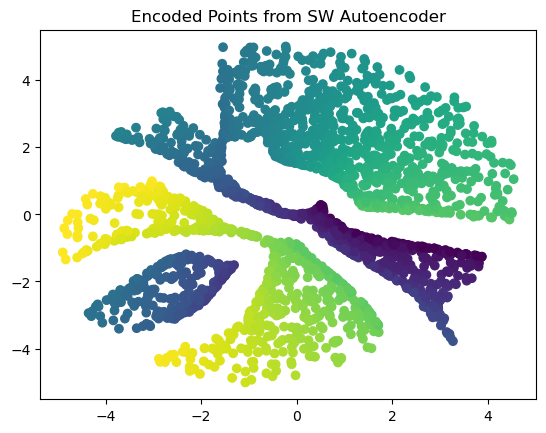

In [251]:
latent_np = mu.detach().numpy()
x_values = latent_np[:, 0]
y_values = latent_np[:, 1]

plt.scatter(x_values, y_values, c = color)
plt.title("Encoded Points from SW Autoencoder")

###### 1.2.4 Decoded points from prior distribution

Text(0.5, 0.98, 'Decoded points of Samples from VAE Prior Distribution')

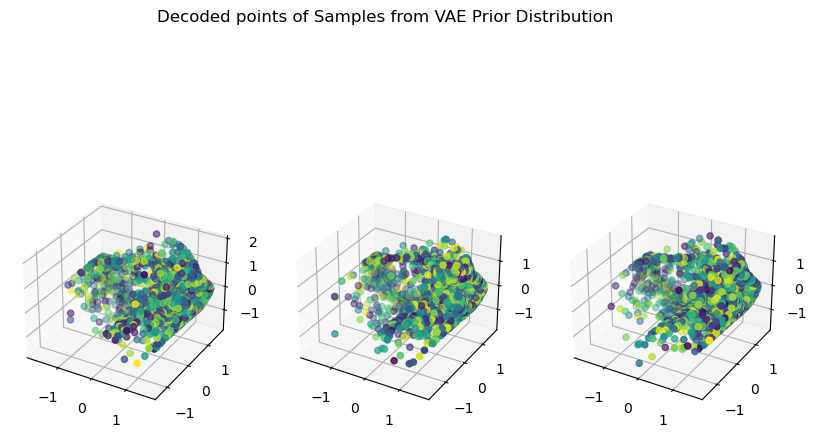

In [253]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
plots = [ax1, ax2, ax3]

for i in range(3):
    sample = dist.MultivariateNormal(torch.zeros(2), torch.eye(2)).sample((2500,))
    output = vae(sample, encoding=False)
    output = output.detach().numpy()
    plots[i].scatter(output[:, 0], output[:, 1], output[:, 2], c = color)

fig.suptitle("Decoded points of Samples from VAE Prior Distribution")

###### Comparing SWAE and VAE
It seems the Sliced Wasserstein method performed better than the variational autoencoder, but it can be difficult to tell based on my muddy results. The reconstruction loss for my VAE was more stable than either the reconstruction loss or the SW loss in my SWAE, but it was more challenging to implement the VAE. The VAE required more fine-tuning, and seemed more sensitive to changes in the hyperparameters. 

##### Question 2: GANs
###### 2.1.1 Training a GAN

In [417]:
class MLP(nn.Module):
    def __init__(self, architecture, disc):
        super().__init__()
        self.activation = nn.ReLU()
        
        arch = []
        for i in range(1, len(architecture)):
            arch.append(nn.Linear(architecture[i-1], architecture[i]))
            if i < len(architecture) - 1:
                arch.append(self.activation)
            elif disc:
                arch.append(nn.Sigmoid())
            
        self.model = nn.Sequential(*arch)
    
    def forward(self, x):
        out = self.model(x)
        return(out)

In [470]:
gen_architecture = [2, 512, 512, 3]
disc_architecture = [3, 512, 512, 1]

generator = MLP(architecture=gen_architecture, disc=False).to(device)
discriminator = MLP(architecture=disc_architecture, disc=True).to(device)

goptimizer = torch.optim.Adam(encoder.parameters(), lr=1e-4)
doptimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
# print(encoder)
# print(discriminator)

In [471]:
# Going from prior distribution to swiss roll
epochs = 10001
Disc_Losses = []
Gen_Losses = []
xt = torch.FloatTensor(x).to(device)
for e in range(epochs):
    xin = dist.MultivariateNormal(torch.zeros(2), torch.eye(2)).sample((2500,)).to(device)
    xhat = generator(xin).detach()
    disc_losses = []
    
    for i in range(5):
        disc_true = discriminator(xt)
        disc_false = discriminator(xhat.data)
        disc_loss = -(torch.mean(torch.log(disc_true+1e-10))+torch.mean(torch.log(1-disc_false+1e-10)))               
        doptimizer.zero_grad()
        disc_loss.backward()
        doptimizer.step()
        disc_losses.append(disc_loss)
        
    Disc_Losses.append(torch.mean(torch.FloatTensor(disc_losses)))
    gen_loss = torch.mean(torch.log(1-discriminator(xhat)+1e-10))
    Gen_Losses.append(gen_loss)
    
    goptimizer.zero_grad()
    gen_loss.backward()
    goptimizer.step()


    if e % 500 == 0:
        print(f"Epoch: {e} | G Loss: {gen_loss:f} | D Loss: {disc_loss:f}")


Epoch: 0 | G Loss: -0.650147 | D Loss: 1.312490
Epoch: 500 | G Loss: -0.000210 | D Loss: 0.000388
Epoch: 1000 | G Loss: -0.000021 | D Loss: 0.000047
Epoch: 1500 | G Loss: -0.000006 | D Loss: 0.000012
Epoch: 2000 | G Loss: -0.000003 | D Loss: 0.000004
Epoch: 2500 | G Loss: -0.000000 | D Loss: 0.000001
Epoch: 3000 | G Loss: -0.000000 | D Loss: 0.000000
Epoch: 3500 | G Loss: -0.000000 | D Loss: 0.000000
Epoch: 4000 | G Loss: -0.000000 | D Loss: 0.000000
Epoch: 4500 | G Loss: -0.000000 | D Loss: 0.000000
Epoch: 5000 | G Loss: -0.000000 | D Loss: 0.000000
Epoch: 5500 | G Loss: -0.000000 | D Loss: 0.000000
Epoch: 6000 | G Loss: 0.000000 | D Loss: 0.000000
Epoch: 6500 | G Loss: 0.000000 | D Loss: 0.000000
Epoch: 7000 | G Loss: -0.000000 | D Loss: 0.000000


KeyboardInterrupt: 

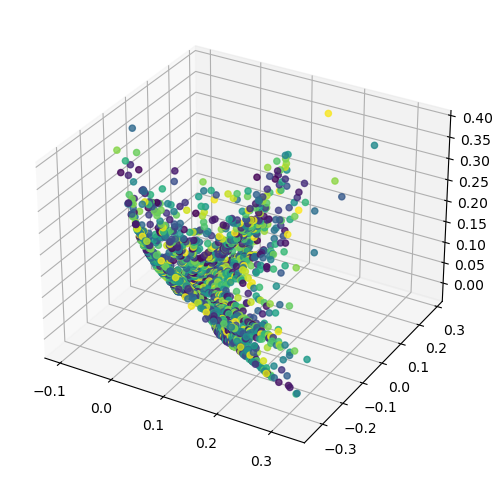

In [472]:
xnew = xhat.detach()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(xnew[:, 0], xnew[:, 1], xnew[:, 2], c = color, alpha=0.8)

###### 2.1.2 Generator and Discriminator Loss

Text(0, 0.5, 'Loss')

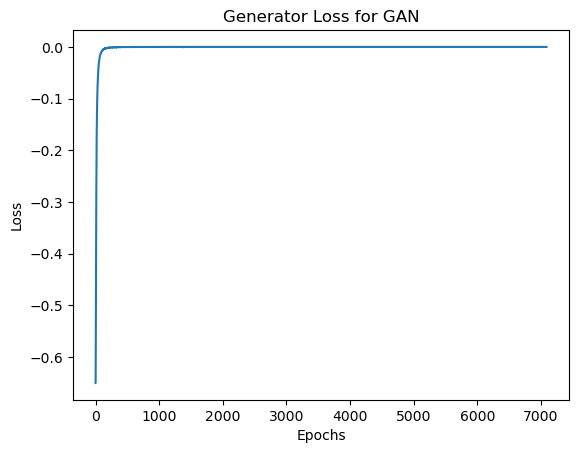

In [473]:
gen_np = [x.detach().numpy() for x in Gen_Losses]
plt.plot(gen_np)
plt.title("Generator Loss for GAN")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

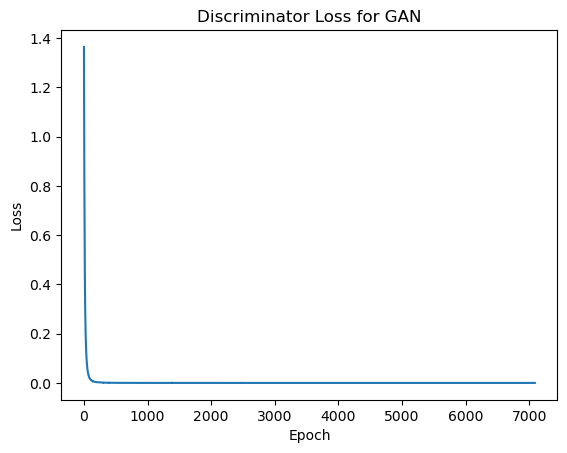

In [474]:
disc_np = [x.numpy() for x in Disc_Losses]
plt.plot(disc_np)
plt.title("Discriminator Loss for GAN")
plt.xlabel("Epoch")
plt.ylabel("Loss")

###### 2.1.3 Generated samples from prior distribution

Text(0.5, 0.98, 'Generated Samples from GAN')

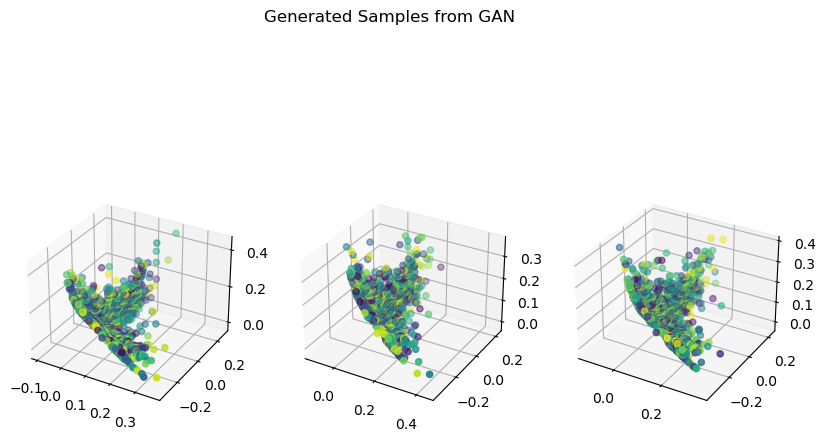

In [475]:
### Need to redo
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
plots = [ax1, ax2, ax3]

for i in range(3):
    sample = dist.MultivariateNormal(torch.zeros(2), torch.eye(2)).sample((2500,))
    output = generator(sample)
    output = output.detach().numpy()
    plots[i].scatter(output[:, 0], output[:, 1], output[:, 2], c = color)

fig.suptitle("Generated Samples from GAN")

###### 2.2.1 Training a SW GAN

In [463]:
# original architecture [2, 256, 512, 1024, 512, 256, 3]
swgan_arch = encoder_architecture = [2, 256, 512, 1024, 512, 256, 3]
swgan = MLP(architecture=swgan_arch, disc=False)

In [464]:
swgan_optimizer = torch.optim.Adam(swgan.parameters(), lr=0.000001)

In [465]:
epochs = 10001
xt = torch.FloatTensor(x)
gen_loss = []

for e in range(epochs):
    xin_sw = dist.MultivariateNormal(torch.zeros(2), torch.eye(2)).sample((2500,))#torch.randn(2500, 2)
    xhat_sw = swgan(xin_sw)    
    loss = sliced_wass(xhat_sw, xt, 512)
    gen_loss.append(loss.detach().numpy())
    swgan_optimizer.zero_grad()
    loss.backward()
    swgan_optimizer.step()

    if e % 500 == 0:
        print(f"Epoch: {e} | SW Loss: {loss:.4f}")

Epoch: 0 | SW Loss: 0.9697
Epoch: 500 | SW Loss: 0.8378
Epoch: 1000 | SW Loss: 0.4963
Epoch: 1500 | SW Loss: 0.1722
Epoch: 2000 | SW Loss: 0.1294
Epoch: 2500 | SW Loss: 0.1103
Epoch: 3000 | SW Loss: 0.1008
Epoch: 3500 | SW Loss: 0.0894
Epoch: 4000 | SW Loss: 0.0785
Epoch: 4500 | SW Loss: 0.0819
Epoch: 5000 | SW Loss: 0.0745
Epoch: 5500 | SW Loss: 0.0703
Epoch: 6000 | SW Loss: 0.0717
Epoch: 6500 | SW Loss: 0.0699
Epoch: 7000 | SW Loss: 0.0750
Epoch: 7500 | SW Loss: 0.0702
Epoch: 8000 | SW Loss: 0.0778
Epoch: 8500 | SW Loss: 0.0718
Epoch: 9000 | SW Loss: 0.0710
Epoch: 9500 | SW Loss: 0.0781
Epoch: 10000 | SW Loss: 0.0723


###### 2.2.2 Generator Loss

Text(0.5, 1.0, 'Generator Loss from SW GAN')

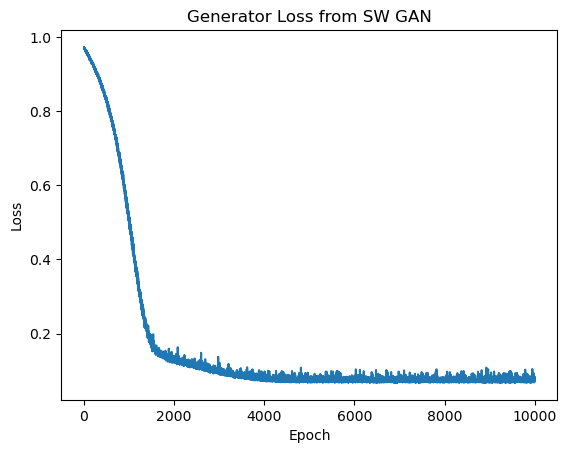

In [466]:
plt.plot(gen_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss from SW GAN")

###### 2.2.3 Generated samples from prior distribution

Text(0.5, 0.98, 'Generated Samples from SW GAN')

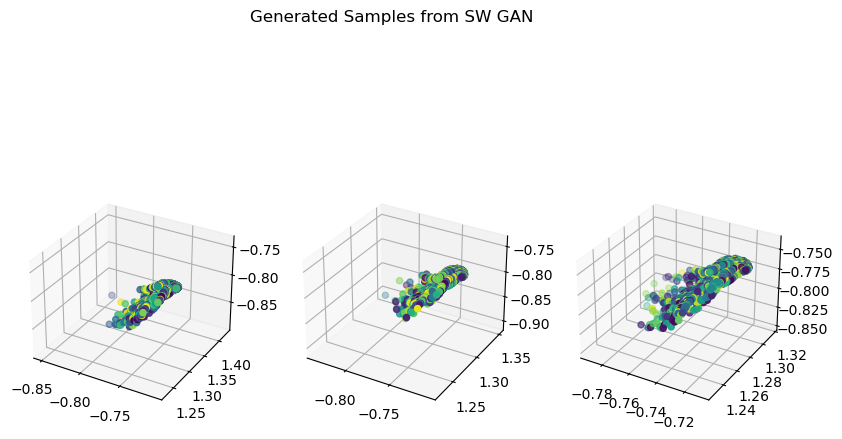

In [467]:
swgan.eval()
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
plots = [ax1, ax2, ax3]

for i in range(3):
    sample = dist.MultivariateNormal(torch.zeros(2), torch.eye(2)).sample((2500,))
    output = swgan(sample)
    output = output.detach().numpy()
    plots[i].scatter(output[:, 0], output[:, 1], output[:, 2], c = color)

fig.suptitle("Generated Samples from SW GAN")

###### Comparing the two approaches to GANs

I felt that both the Sliced-Wasserstein GAN and the regular GAN were difficult to train. In theory the SW GAN should have been more straightforward since it only requires the Sliced Wasserstein distane in the loss term, as opposed to the regular GAN which has two competing losses (discriminator and generator). 
That being said, neither of my GANs works particularly well, so I do not have the best insights. I did learn in lectures and in my conversations with other classmates that the GAN should give a cleaner result since the discriminator enforces a close match between the prior and the generator's output. The final result from the SW method might not be as clean, but the training process should be faster. 

##### Question 3: Self Supervised Learning
###### 3.1 Training a linear classifier on encoded representations

In [344]:
# Loading in MNIST dataset
transform1 = transform.Compose([transform.ToTensor(), 
                              transform.Normalize((0.5,), (0.5))])
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform1, download=True)

In [345]:
tensor = transform.ToTensor()
train_images = np.array(mnist_train.data)

mnist_train2 = []
rotated_label = []
for i in range(len(train_images)):
    angle = random.sample([0, 90, 180, 270], 1)
    img = train_images[i]
    pil_img = Image.fromarray(img)
    rotated_img = pil_img.rotate(angle[0])
    rot_tensor = tensor(rotated_img)
    mnist_train2.append(rot_tensor)
    rotated_label.append(angle[0]/90)

rotated_mnist = torch.cat(mnist_train2)
rotated_label = torch.Tensor(rotated_label)

In [346]:
trainloader = torch.utils.data.DataLoader(rotated_mnist, batch_size=32, shuffle=False, num_workers=2)
ogloader = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=False, num_workers=2)

In [347]:
# CNN for MNIST accuracy
class Net(nn.Module):
    def __init__(self, encoding):
        super(Net, self).__init__()
        self.activation = nn.ReLU()
        self.model=nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5), 
            self.activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            self.activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=512,out_features=256),
            self.activation,
            nn.Linear(in_features=256, out_features=128),#)
            self.activation)
        self.final = nn.Linear(in_features=128, out_features=4)
            
    def forward(self, x, encoding):
        out = self.model(x)
        if encoding:
            out = self.final(out)
        return out

net = Net(encoding=True)
print(net)

Net(
  (activation): ReLU()
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
  )
  (final): Linear(in_features=128, out_features=4, bias=True)
)


In [348]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(torch.round(y_true), torch.round(y_pred)).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [349]:
epochs = 5

for e in range(epochs+1):
    for i, batch in enumerate(trainloader, 0):
        inpt = batch.unsqueeze(1)
        label = rotated_label[(i*32):(i*32)+32].long()
        y_logits = net(inpt, encoding=True)
        
        loss = criterion(y_logits, label)
        acc = accuracy_fn(y_true=label,y_pred=y_logits.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 500 == 0:
            print(f"{e}| Batch {i} | Accuracy: {acc:.4f}| Loss: {loss.item():.4f}")

0| Batch 0 | Accuracy: 25.0000| Loss: 1.4005
0| Batch 500 | Accuracy: 90.6250| Loss: 0.2993
0| Batch 1000 | Accuracy: 100.0000| Loss: 0.0119
0| Batch 1500 | Accuracy: 93.7500| Loss: 0.1150
1| Batch 0 | Accuracy: 100.0000| Loss: 0.0419
1| Batch 500 | Accuracy: 90.6250| Loss: 0.1381
1| Batch 1000 | Accuracy: 100.0000| Loss: 0.0236
1| Batch 1500 | Accuracy: 90.6250| Loss: 0.1481
2| Batch 0 | Accuracy: 100.0000| Loss: 0.0286
2| Batch 500 | Accuracy: 93.7500| Loss: 0.1594
2| Batch 1000 | Accuracy: 100.0000| Loss: 0.0041
2| Batch 1500 | Accuracy: 100.0000| Loss: 0.0195
3| Batch 0 | Accuracy: 96.8750| Loss: 0.0883
3| Batch 500 | Accuracy: 93.7500| Loss: 0.2051
3| Batch 1000 | Accuracy: 100.0000| Loss: 0.0014
3| Batch 1500 | Accuracy: 100.0000| Loss: 0.0013
4| Batch 0 | Accuracy: 100.0000| Loss: 0.0110
4| Batch 500 | Accuracy: 96.8750| Loss: 0.0382
4| Batch 1000 | Accuracy: 100.0000| Loss: 0.0073
4| Batch 1500 | Accuracy: 93.7500| Loss: 0.2088
5| Batch 0 | Accuracy: 100.0000| Loss: 0.0178
5| B

In [350]:
for param in net.parameters():
    param.requires_grad = False

In [357]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.model = nn.Sequential(
            nn.Linear(in_features=128, out_features=512),
            self.activation,
            nn.Linear(in_features=512, out_features=128),
            self.activation,
            nn.Linear(in_features=128, out_features=10)
        )
        
    def forward(self, x):
        return self.model(x)
    
classy = Classifier()

In [358]:
criterion = nn.CrossEntropyLoss()
classy_optimizer = torch.optim.Adam(classy.parameters(), lr=0.0001) 

In [359]:
epochs = 5
net.eval()
predictions = []
true_labels = []

for e in range(epochs+1):
    for i, batch in enumerate(ogloader, 0):
        inpt, label = batch
        rotated_logits = net(inpt, encoding=False)
        y_logits = classy(rotated_logits)
        y_pred = F.softmax(y_logits, dim=1)
        loss = criterion(y_pred, label)
        acc = accuracy_fn(y_true=label,y_pred=y_pred.argmax(dim=1))
        
        predictions.append(y_logits.argmax(dim=1).detach().numpy())
        true_labels.append(label)

        classy_optimizer.zero_grad()
        loss.backward()
        classy_optimizer.step()

        if i % 500 == 0:
            print(f"{e}| Batch {i} | Accuracy: {acc:.4f}| Loss: {loss.item():.4f}")

0| Batch 0 | Accuracy: 6.2500| Loss: 2.3321
0| Batch 500 | Accuracy: 37.5000| Loss: 2.0888
0| Batch 1000 | Accuracy: 53.1250| Loss: 1.9288
0| Batch 1500 | Accuracy: 59.3750| Loss: 1.9127
1| Batch 0 | Accuracy: 65.6250| Loss: 1.8416
1| Batch 500 | Accuracy: 50.0000| Loss: 1.9619
1| Batch 1000 | Accuracy: 62.5000| Loss: 1.8742
1| Batch 1500 | Accuracy: 62.5000| Loss: 1.8479
2| Batch 0 | Accuracy: 75.0000| Loss: 1.7706
2| Batch 500 | Accuracy: 56.2500| Loss: 1.8973
2| Batch 1000 | Accuracy: 71.8750| Loss: 1.8176
2| Batch 1500 | Accuracy: 65.6250| Loss: 1.8202
3| Batch 0 | Accuracy: 75.0000| Loss: 1.7646
3| Batch 500 | Accuracy: 62.5000| Loss: 1.8604
3| Batch 1000 | Accuracy: 71.8750| Loss: 1.7725
3| Batch 1500 | Accuracy: 65.6250| Loss: 1.8103
4| Batch 0 | Accuracy: 75.0000| Loss: 1.7412
4| Batch 500 | Accuracy: 65.6250| Loss: 1.8435
4| Batch 1000 | Accuracy: 71.8750| Loss: 1.7620
4| Batch 1500 | Accuracy: 71.8750| Loss: 1.7551
5| Batch 0 | Accuracy: 81.2500| Loss: 1.6727
5| Batch 500 | A

###### 3.2 Confusion Matrix and Interpretation

In [ ]:
true_labels = np.concatenate(true_labels)
predictions = np.concatenate(predictions)

Text(0.5, 1.0, 'Confusion Matrix for MNIST Classifier that had a RotNet Pretext Task')

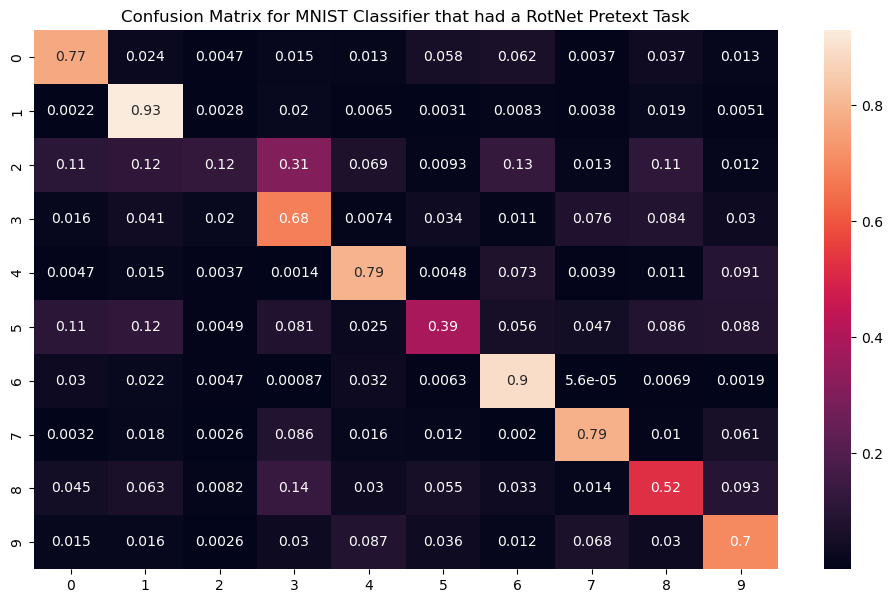

In [383]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

cf_matrix = confusion_matrix(true_labels, predictions)

confusion_df = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], 
                           index   = [i for i in classes], 
                           columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(confusion_df, annot=True)
plt.title("Confusion Matrix for MNIST Classifier that had a RotNet Pretext Task")

###### 3.3 SSL vs. Linear Classifier

In [384]:
# CNN for MNIST accuracy
class LinClassifier(nn.Module):
    def __init__(self):
        super(LinClassifier, self).__init__()
        self.activation = nn.ReLU()
        self.model=nn.Sequential(
            nn.Linear(in_features=784, out_features=512),
            self.activation,
            nn.Linear(in_features=512, out_features=128),
            self.activation,
            nn.Linear(in_features=128, out_features=10)
        )
            
    def forward(self, x):
        out = self.model(x.reshape(32, 784))
        return out

lin = LinClassifier()
print(lin)

LinClassifier(
  (activation): ReLU()
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [385]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lin.parameters(), lr=0.0001)

In [386]:
epochs = 5

for e in range(epochs):
    for i, batch in enumerate(ogloader):
        inputs, labels = batch
        inputs = inputs / 255.0
        outputs = lin(inputs)
        y_pred = F.softmax(outputs, dim=1)
        loss = criterion(y_pred, labels)
        accuracy = accuracy_fn(y_true=labels,y_pred=y_pred.argmax(dim=1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print(f"Epoch {e} | Batch: {i} | Loss {loss:.4f} | Acc {accuracy:.4f}")

Epoch 0 | Batch: 0 | Loss 2.3031 | Acc 9.3750
Epoch 0 | Batch: 500 | Loss 2.2911 | Acc 12.5000
Epoch 0 | Batch: 1000 | Loss 2.1978 | Acc 18.7500
Epoch 0 | Batch: 1500 | Loss 2.1076 | Acc 31.2500
Epoch 1 | Batch: 0 | Loss 2.0320 | Acc 43.7500
Epoch 1 | Batch: 500 | Loss 2.0818 | Acc 40.6250
Epoch 1 | Batch: 1000 | Loss 1.9345 | Acc 59.3750
Epoch 1 | Batch: 1500 | Loss 1.9404 | Acc 53.1250
Epoch 2 | Batch: 0 | Loss 1.8712 | Acc 62.5000
Epoch 2 | Batch: 500 | Loss 1.9452 | Acc 53.1250
Epoch 2 | Batch: 1000 | Loss 1.7841 | Acc 78.1250
Epoch 2 | Batch: 1500 | Loss 1.8336 | Acc 62.5000
Epoch 3 | Batch: 0 | Loss 1.8376 | Acc 62.5000
Epoch 3 | Batch: 500 | Loss 1.8526 | Acc 65.6250
Epoch 3 | Batch: 1000 | Loss 1.6966 | Acc 84.3750
Epoch 3 | Batch: 1500 | Loss 1.7821 | Acc 71.8750
Epoch 4 | Batch: 0 | Loss 1.8229 | Acc 62.5000
Epoch 4 | Batch: 500 | Loss 1.7946 | Acc 78.1250
Epoch 4 | Batch: 1000 | Loss 1.6497 | Acc 90.6250
Epoch 4 | Batch: 1500 | Loss 1.7400 | Acc 81.2500


###### Comparing the results
Even though I only use a linear classifier above, this model's performance is competitive with classifier built on top of the self-supervised RotNet. Based on the confusion matrix, it seems the model struggled with specific digits, which likely harmed its performance. For instance, the model had a particularly difficult time with 2s, and actually classified them as 3s more often. There seem to be other numbers, when rotated, that can easily be confused with others, such as 5s, 8s, and 3s. By contrast, this model was especially good at classifying 1s, 6s, 4s, and 7s. I am surprised the 6s were not confused with 9s more often, but unsurprisingly, it would be easier to identify the angle of rotation for these well-classified numbers.